# Solution
In solving this task I applied the following circuit architecture:

$R_x$ followed by $R_y$ appliled on qubit 0

A controlled-not gate between qubit 0 and qubit 1

$R_x$ followed by $R_y$ appliled on qubit 1

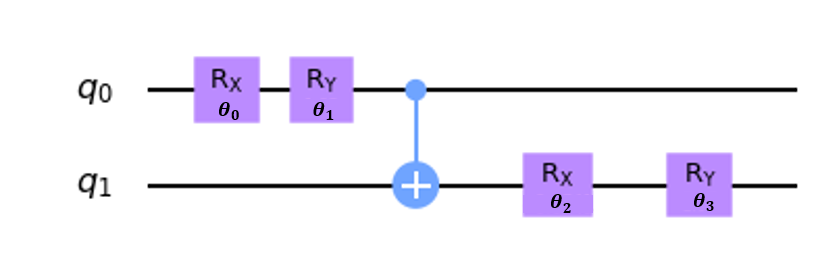

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$ $$\newcommand{\expectation}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
This was the circuit architicture itself but to do the optimization needed to generate the bell state $\ket{\Psi^{01}}=\frac{1}{\sqrt{2}}(\ket{01} + \ket{10})$ I applied one more controlled-not gate between qubit 0 and qubit 1. This will help identify that we truely have the intended Bell state and not any other state with a relative phase. 

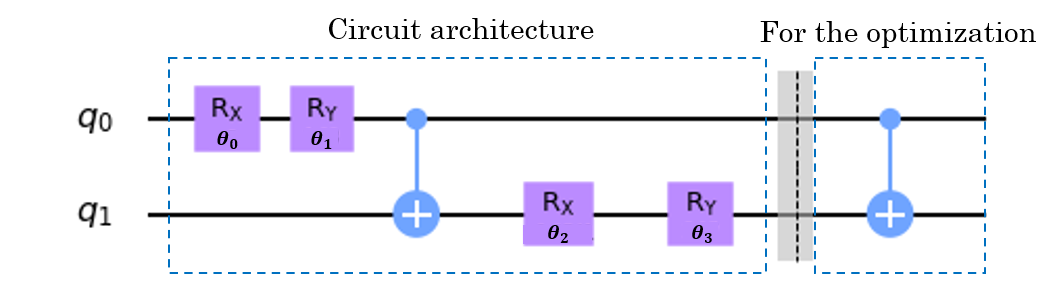

Once we apply the controlled-not gate we can see that if we want to have the $\ket{\Psi^{01}}$ state then we have to measure -1 on qubit 1 (which tells us that the two qubits are different). But that is not all, we also have to check that qubit 0 is in the $\ket{+}$ state by measuring along the x and obtaining a +1. This will ensure that we have a $\ket{\Psi^{01}}$ and not any other state. 

The mathmatics will clear things up. Our target is to obtain the state $\ket{\Psi^{01}}=\frac{1}{\sqrt{2}}(\ket{01} + \ket{10})$. Now if we apply a CNOT, we will get the following:
$$CNOT\ket{\Psi^{01}}=\frac{1}{\sqrt{2}}(CNOT\ket{01} + CNOT\ket{10})$$
$$ = \frac{1}{\sqrt{2}}(\ket{01} + \ket{11})$$
$$ = \ket{+} \otimes \ket{1}$$

Now once we add the CNOT gate our target would be to find +1 for the expectation value of the PauliX operator on qubit 0 (measurement along x should ideally yield +1) and we should ideally get -1 for the expectaion value of the PauliZ operator. 
We can do this by minimizing the the following cost:
$$cost = \langle Z \rangle - \langle X \rangle$$

I did the optimization on two simulators, A noiseless one and another one with noise.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

Do the optimization on a noiseless simulator

In [2]:
dev_noiseless = qml.device('default.qubit', wires=2, shots=1024, analytic=False)

@qml.qnode(dev_noiseless)
def circuit(thetas):
    
    # Apply parametric gates on qubit 0
    qml.RX(thetas[0], wires = 0)
    qml.RY(thetas[1], wires = 0)
    
    # Apply a contolled not gate bewtween qubit 0 and qubit 1
    qml.CNOT(wires = [0, 1])
    
    # Apply parametric gates on qubit 1
    qml.RX(thetas[2], wires = 1)
    qml.RY(thetas[3], wires = 1)
    
    # Apply CNOT for the optimization step 
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliZ(1))

In [3]:
def cost(thetas):
    # The cost function defined so that when it is minimized we ideally should get the desired Bell state
    C = circuit(thetas)
    return C[1] - C[0]

In [4]:
# We use the Adam optimizer with step size 0.1 and we use a tolerance of 0.2 as a stopping criteria 

tol = 0.02

opt = qml.AdamOptimizer(0.1)

# Initialize the parameters to zero
thetas_noiseless = np.zeros(4)

# A list containing the costs in each iteration 
costs_noiseless = []

while cost(thetas_noiseless) > -2 + tol:
    thetas_noiseless = opt.step(cost, thetas_noiseless)
    costs_noiseless.append(cost(thetas_noiseless))
    

The optimum values for the parameters are [-0.08781541  1.5778328  -3.24938139  0.11317726]


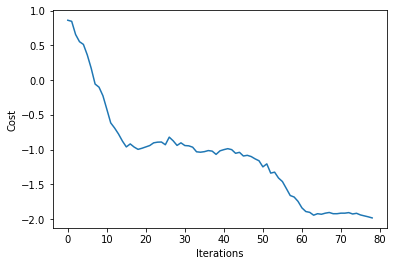

In [5]:
# The optimum values of the parameters
print('The optimum values for the parameters are ' +  str(thetas_noiseless))

# Plot the cost vs interations p
plt.plot(costs_noiseless)
plt.ylabel('Cost');
plt.xlabel('Iterations');

In [6]:
# Show the expextation values of the Paulix on qubit 0 and the Pauliz on qubit 1 
# Ideally we should get [1, -1]

print(circuit(thetas_noiseless))

[ 0.99414062 -0.99023438]


Do the optimization on a qiskit noise model from the backend properities of the device 'IBMQ Vigo'

In [7]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
provider = IBMQ.load_account()

C:\Users\Ali\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [8]:
# The noise model from the backend properties 
backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

dev_noise = qml.device('qiskit.aer', wires=2, noise_model=noise_model, shots = 1024)

@qml.qnode(dev_noise)
def circuit(thetas):
    
    
    qml.RX(thetas[0], wires = 0)
    qml.RY(thetas[1], wires = 0)
    
    qml.CNOT(wires = [0, 1])
    
    qml.RX(thetas[2], wires = 1)
    qml.RY(thetas[3], wires = 1)
    
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliZ(1))

In [9]:
def cost(thetas):
    # The cost function defined so that when it is minimized we ideally should get the desired Bell state
    C = circuit(thetas)
    return C[1] - C[0]

In [10]:
# We use the Adam optimizer with step size 0.1 and we use a tolerance of 0.2 as a stopping criteria 

tol = 0.2

opt = qml.AdamOptimizer(0.1)

# Initialize the parameters to zero
thetas_noise = np.zeros(4)

# A list containing the costs in each iteration 
costs_noise = []

while cost(thetas_noise) > -2 + tol:
    thetas_noise = opt.step(cost, thetas_noise)
    costs_noise.append(cost(thetas_noise))

The optimum values for the parameters are [-3.30201918  1.50608131  0.22837535 -3.030718  ]


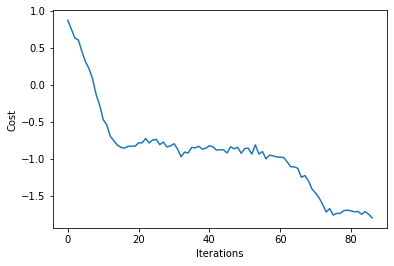

In [11]:
# The optimum values of the parameters
print('The optimum values for the parameters are ' +  str(thetas_noise))

# Plot the cost vs interations 
plt.plot(costs_noise)
plt.ylabel('Cost');
plt.xlabel('Iterations');

In [12]:
# Show the expextation values of the Paulix on qubit 0 and the Pauliz on qubit 1 
# Ideally we should get [1, -1]

print(circuit(thetas_noise))

[ 0.88476562 -0.85546875]


# Results
We show the results form toptimizing on a noiseless simulator here.

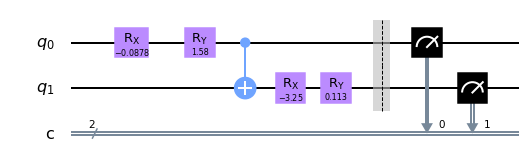

In [13]:
# Here we show the results of applying the circuit architecture with the optimum values obtained from the noiseless simulator

thetas = thetas_noiseless


qc = QuantumCircuit(2, 2)

qc.rx(thetas[0], 0)
qc.ry(thetas[1], 0)

qc.cx(0, 1)
    
qc.rx(thetas[2], 1)
qc.ry(thetas[3], 1)
qc.barrier()

qc.measure([0,1], [0,1])


qc.draw('mpl')

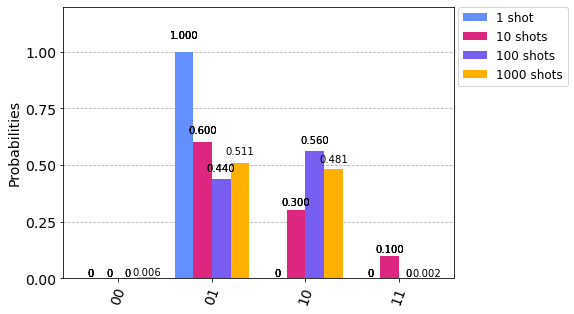

In [14]:
shots = [1, 10, 100, 1000]
counts = []
for i in shots:
    
    result = execute(qc, Aer.get_backend('qasm_simulator'), shots = i).result()
    counts.append(result.get_counts(qc))

plot_histogram(counts, legend=["1 shot", "10 shots", "100 shots", "1000 shots"])

We also show the results form optimizing on a noisy simulator here.

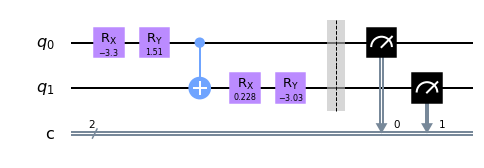

In [15]:
# Here we show the results of applying the circuit architecture with the optimum values obtained from the noisy simulator

thetas = thetas_noise

# The noise model from the backend properties 
backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

qc = QuantumCircuit(2, 2)

qc.rx(thetas[0], 0)
qc.ry(thetas[1], 0)

qc.cx(0, 1)
    
qc.rx(thetas[2], 1)
qc.ry(thetas[3], 1)
qc.barrier()

qc.measure([0,1], [0,1])


qc.draw('mpl')

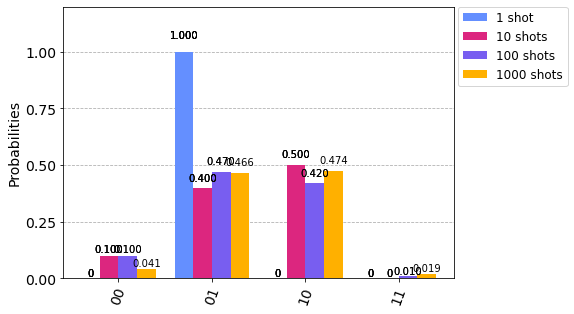

In [16]:
shots = [1, 10, 100, 1000]
counts = []
for i in shots:
    
    result = execute(qc, Aer.get_backend('qasm_simulator'), coupling_map=coupling_map, basis_gates=basis_gates, 
                     noise_model=noise_model, shots = i).result()
    counts.append(result.get_counts(qc))


plot_histogram(counts, legend=["1 shot", "10 shots", "100 shots", "1000 shots"])

# Bonus 
The method I used here already makes sure that we have the state  $\ket{\Psi^{01}}=\frac{1}{\sqrt{2}}(\ket{01} + \ket{10})$ and not any other combination with a non-zero relative phase.